In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

In [2]:
import sys
sys.path.append('..')

In [14]:
import mysecrets
import config
import fetch_from_cluster
import catalogmanager
import sqlite_db_utils

In [4]:
s2_satellite_catalog_gdf = \
fetch_from_cluster.load_satellite_sentinel2_catalog(
    sshcreds = mysecrets.SSH_UMD,
    satellite_folderpath = config.FOLDERPATH_SATELLITE,
    overwrite = True,
)

In [ ]:
s2_satellite_catalog_gdf.shape

(3863, 9)

In [7]:
s2_satellite_catalog_gdf.columns

Index(['id', 'satellite', 'timestamp', 's3url', 'local_folderpath', 'files',
       'last_update', 'cloud_cover', 'geometry'],
      dtype='object')

In [9]:
s2_satellite_catalog_gdf['last_update']

0      2024-08-20 13:54:40.022000+00:00
1      2024-08-20 13:54:40.023000+00:00
2      2024-08-20 13:54:40.025000+00:00
3      2024-08-20 13:54:40.027000+00:00
4      2024-08-20 13:54:40.028000+00:00
                     ...               
3858   2025-01-27 13:46:11.388000+00:00
3859   2025-01-27 13:46:59.394000+00:00
3860   2025-01-27 13:46:59.396000+00:00
3861   2025-01-27 13:46:59.399000+00:00
3862   2025-01-27 13:46:59.401000+00:00
Name: last_update, Length: 3863, dtype: datetime64[ms, UTC]

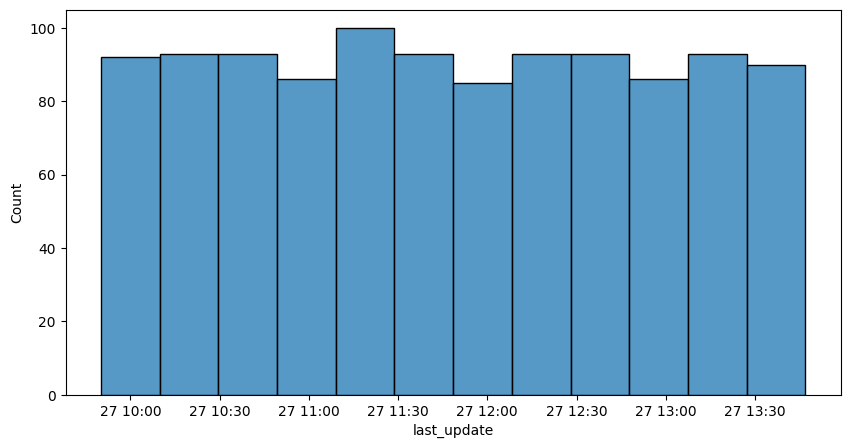

In [13]:
scale = 5
aspect_ratio = 2
fig, ax = plt.subplots(figsize=(scale*aspect_ratio, scale))

g = sns.histplot(
    data = s2_satellite_catalog_gdf[
        s2_satellite_catalog_gdf['last_update'] >= catalogmanager.dt2ts(dt=datetime.datetime(2025, 1, 1))
    ],
    x = 'last_update',
)

### geojson to db

In [20]:
catalog_filepath = fetch_from_cluster.remotepath_to_localpath(
    remotepath = fetch_from_cluster.FILEPATH_SATELLITE_SENTINEL2_CATALOG,
    remote_root_path = fetch_from_cluster.FOLDERPATH_SATELLITE,
    local_root_path = config.FOLDERPATH_SATELLITE,
)
catalog_filepath

'/Users/nikhilsrajan/NASA-Harvest/project/fetch_satdata/notebooks/../data/satellite/Sentinel-2/catalog.geojson'

In [21]:
db_path = catalog_filepath.replace('.geojson', '.db')
db_path

'/Users/nikhilsrajan/NASA-Harvest/project/fetch_satdata/notebooks/../data/satellite/Sentinel-2/catalog.db'

In [26]:
table_name = 'satellite'

In [27]:
if not os.path.exists(db_path):
    sqlite_db_utils.create_db(
        db_path = db_path,
        table_name = table_name,
        col_type_dict = {
            'id': 'TEXT UNIQUE',
            'satellite': 'TEXT',
            'timestamp': 'TEXT',
            's3url': 'TEXT',
            'local_folderpath': 'TEXT',
            'files': 'TEXT',
            'last_update': 'TEXT',
            'cloud_cover': 'REAL',
            'geometry': 'TEXT',
        },
        id_col = 'id',
    )

In [28]:
for index, row in s2_satellite_catalog_gdf.iterrows():
    sql_row = sqlite_db_utils.gpd_to_sql_row(row_dict=row)
    sqlite_db_utils.insert_row_to_db(
        database = db_path,
        table = table_name,
        data_dict = sql_row,
    )

In [33]:
db_gdf = sqlite_db_utils.fetch_rows_from_db(
    database = db_path,
    table = table_name,
    columns = ['id', 'geometry']
)

SELECT id, geometry FROM satellite 


In [34]:
db_gdf

,id,geometry
0,S2A_MSIL1C_20211224T074331_N0500_R092_T37PDK_2...,"MULTIPOLYGON (((38.16166 9.04578, 39.0888 9.04..."
1,S2B_MSIL1C_20210413T073609_N0500_R092_T37PEK_2...,"MULTIPOLYGON (((38.99983 9.04673, 39.99885 9.0..."
2,S2A_MSIL1C_20211114T074151_N0500_R092_T37PDK_2...,"MULTIPOLYGON (((38.16657 9.04579, 39.0888 9.04..."
3,S2A_MSIL1C_20211204T074301_N0500_R092_T37NEJ_2...,"MULTIPOLYGON (((38.99983 8.14202, 39.99648 8.1..."
4,S2B_MSIL1C_20211129T074149_N0500_R092_T37NDJ_2...,"MULTIPOLYGON (((38.09192 8.14101, 39.08859 8.1..."
...,...,...
3858,S2A_MSIL1C_20191006T073801_N0500_R092_T37NDH_2...,"MULTIPOLYGON (((38.09384 7.23692, 39.0884 7.23..."
3859,S2A_MSIL1C_20190621T074621_N0500_R135_T37NBH_2...,"MULTIPOLYGON (((36.28333 7.22972, 37.27716 7.2..."
3860,S2B_MSIL1C_20191004T074749_N0500_R135_T37NCJ_2...,"MULTIPOLYGON (((37.18479 8.13797, 38.16667 8.1..."
3861,S2A_MSIL1C_20190731T074621_N0500_R135_T37NCH_2...,"MULTIPOLYGON (((37.18863 7.23422, 37.95432 7.2..."


In [ ]:
selected_id = s2_satellite_catalog_gdf['id'][0]
selected_id

In [ ]:
selected_id = s2_satellite_catalog_gdf['id'][0]
selected_id

In [7]:
satellite_filepaths = fetch_from_cluster.download_sentinel2_satellite(
    id = selected_id,
    sshcreds = mysecrets.SSH_UMD,
    satellite_folderpath = config.FOLDERPATH_SATELLITE,
)

In [ ]:
satellite_filepaths